## Experiment 01: Gemini Embedding PCA Visualization

### Goal
Visualize Gemini text embeddings of IMO Shortlist 2023 problems using PCA (2D/3D) to see if problems cluster by mathematical category (A, N, G, C).

### 1. Imports

In [11]:
import os
import json
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode

# Initialize Plotly for offline notebook use
init_notebook_mode(connected=True)

### 2. Configuration

In [12]:
# Define paths relative to the notebook's location (in experiments/01_.../)
DATA_DIR = '../data/' # Go up one level to experiments/, then into data/
EMBEDDINGS_FILE = os.path.join(DATA_DIR, 'imo_2023_embeddings.npy')
METADATA_FILE = os.path.join(DATA_DIR, 'imo_2023_metadata.json')
OUTPUT_DIR = 'outputs/' # Save plots in a subfolder relative to notebook

# Create output dir if needed
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Plotting constants
N_COMPONENTS_2D = 2
N_COMPONENTS_3D = 3
# Define colors for each category (add more if needed)
CATEGORY_COLORS = {'A': '#e41a1c', 'N': '#377eb8', 'G': '#4daf4a', 'C': '#984ea3', 'unknown': '#cccccc'} # Example colorblind-friendly palette
FIG_SIZE_2D = (12, 10)


### 3. Load Data

In [13]:
print("--- Loading Data ---")
try:
    embeddings = np.load(EMBEDDINGS_FILE, allow_pickle=True)
    print(f"Loaded embeddings from: {EMBEDDINGS_FILE}")
    print(f"Embeddings shape: {embeddings.shape}")

    with open(METADATA_FILE, 'r', encoding='utf-8') as f:
        metadata = json.load(f)
    print(f"Loaded metadata from: {METADATA_FILE}")
    print(f"Number of metadata entries: {len(metadata)}")

    if len(embeddings) != len(metadata):
        raise ValueError("Mismatch between number of embeddings and metadata entries!")

    # Verify embedding dimension consistency (optional, but good check)
    if len(embeddings) > 0:
        first_embedding_len = len(embeddings[0])
        if not all(len(emb) == first_embedding_len for emb in embeddings):
            print("WARNING: Embeddings have inconsistent lengths. This might affect PCA.")
        else:
            print(f"Verified consistent embedding dimension: {first_embedding_len}")
            # Ensure embeddings is a 2D numpy array if not already
            if embeddings.ndim == 1: # Might happen if loaded with object dtype
                embeddings = np.stack(embeddings)
                print(f"Converted embeddings to 2D array. New shape: {embeddings.shape}")


except FileNotFoundError as e:
    print(f"ERROR: Required data file not found: {e}. Please run the embedding generation script first.")
    # Halt execution in a real notebook environment if files are missing
    embeddings = None
    metadata = None
except ValueError as e:
    print(f"ERROR: Data loading validation failed: {e}")
    embeddings = None
    metadata = None
except Exception as e:
    print(f"ERROR: An unexpected error occurred during data loading: {e}")
    embeddings = None
    metadata = None

--- Loading Data ---
Loaded embeddings from: ../data/imo_2023_embeddings.npy
Embeddings shape: (30, 3072)
Loaded metadata from: ../data/imo_2023_metadata.json
Number of metadata entries: 30
Verified consistent embedding dimension: 3072


### 4. Data Preparation (Combine into DataFrame)

In [14]:
if embeddings is not None and metadata is not None:
    print("\n--- Preparing Data ---")
    df = pd.DataFrame(metadata)
    # Ensure embeddings are correctly associated if order is guaranteed
    # (It should be if generated sequentially)
    # Note: Storing large embeddings directly in DataFrame can be memory intensive
    # We'll add PCA components later.
    print("Metadata DataFrame head:")
    print(df.head())
    print(f"\nCategories found: {df['category'].unique()}")
else:
    print("Skipping further steps due to data loading errors.")


--- Preparing Data ---
Metadata DataFrame head:
  problem_id category
0         A1        A
1         A2        A
2         A3        A
3         A4        A
4         A5        A

Categories found: ['A' 'C' 'G' 'N']


### 5. Feature Scaling (Optional but Recommended for PCA)

In [15]:
if embeddings is not None:
    print("\n--- Scaling Embeddings ---")
    scaler = StandardScaler()
    # Fit and transform the embeddings
    scaled_embeddings = scaler.fit_transform(embeddings)
    print(f"Embeddings scaled. Shape: {scaled_embeddings.shape}")


--- Scaling Embeddings ---
Embeddings scaled. Shape: (30, 3072)


### 6. PCA Dimensionality Reduction

In [16]:
if embeddings is not None:
    print("\n--- Performing PCA (2D) ---")
    pca_2d = PCA(n_components=N_COMPONENTS_2D)
    embeddings_2d = pca_2d.fit_transform(scaled_embeddings) # Use scaled embeddings

    print(f"PCA (2D) applied. Reduced shape: {embeddings_2d.shape}")
    print(f"Explained Variance Ratio (2D): {pca_2d.explained_variance_ratio_}")
    total_variance_2d = np.sum(pca_2d.explained_variance_ratio_)
    print(f"Total Explained Variance (2D): {total_variance_2d:.4f}")

    # Add 2D PCA components to DataFrame for plotting
    df['pca1'] = embeddings_2d[:, 0]
    df['pca2'] = embeddings_2d[:, 1]


--- Performing PCA (2D) ---
PCA (2D) applied. Reduced shape: (30, 2)
Explained Variance Ratio (2D): [0.14938475 0.09116394]
Total Explained Variance (2D): 0.2405


#### 6.2 PCA to 3 Dimensions

In [17]:
if embeddings is not None:
    print("\n--- Performing PCA (3D) ---")
    pca_3d = PCA(n_components=N_COMPONENTS_3D)
    embeddings_3d = pca_3d.fit_transform(scaled_embeddings) # Use scaled embeddings

    print(f"PCA (3D) applied. Reduced shape: {embeddings_3d.shape}")
    print(f"Explained Variance Ratio (3D): {pca_3d.explained_variance_ratio_}")
    total_variance_3d = np.sum(pca_3d.explained_variance_ratio_)
    print(f"Total Explained Variance (3D): {total_variance_3d:.4f}")

    # Add 3D PCA component to DataFrame for plotting
    df['pca3'] = embeddings_3d[:, 2]
    print("\nDataFrame head with PCA components:")
    print(df.head())


--- Performing PCA (3D) ---
PCA (3D) applied. Reduced shape: (30, 3)
Explained Variance Ratio (3D): [0.14938474 0.09116158 0.06538674]
Total Explained Variance (3D): 0.3059

DataFrame head with PCA components:
  problem_id category       pca1       pca2       pca3
0         A1        A  -9.318116 -20.924941  10.526694
1         A2        A  -7.049145  18.403018  34.316304
2         A3        A -15.155290 -11.767110  13.282366
3         A4        A -10.920645  27.052267  36.549684
4         A5        A -14.393222 -20.095913  14.731338


### 7. Visualization

#### 7.1 2D Scatter Plot (Matplotlib/Seaborn)


--- Generating 2D Plot ---
Saved 2D plot to: outputs/pca_2d_plot.png


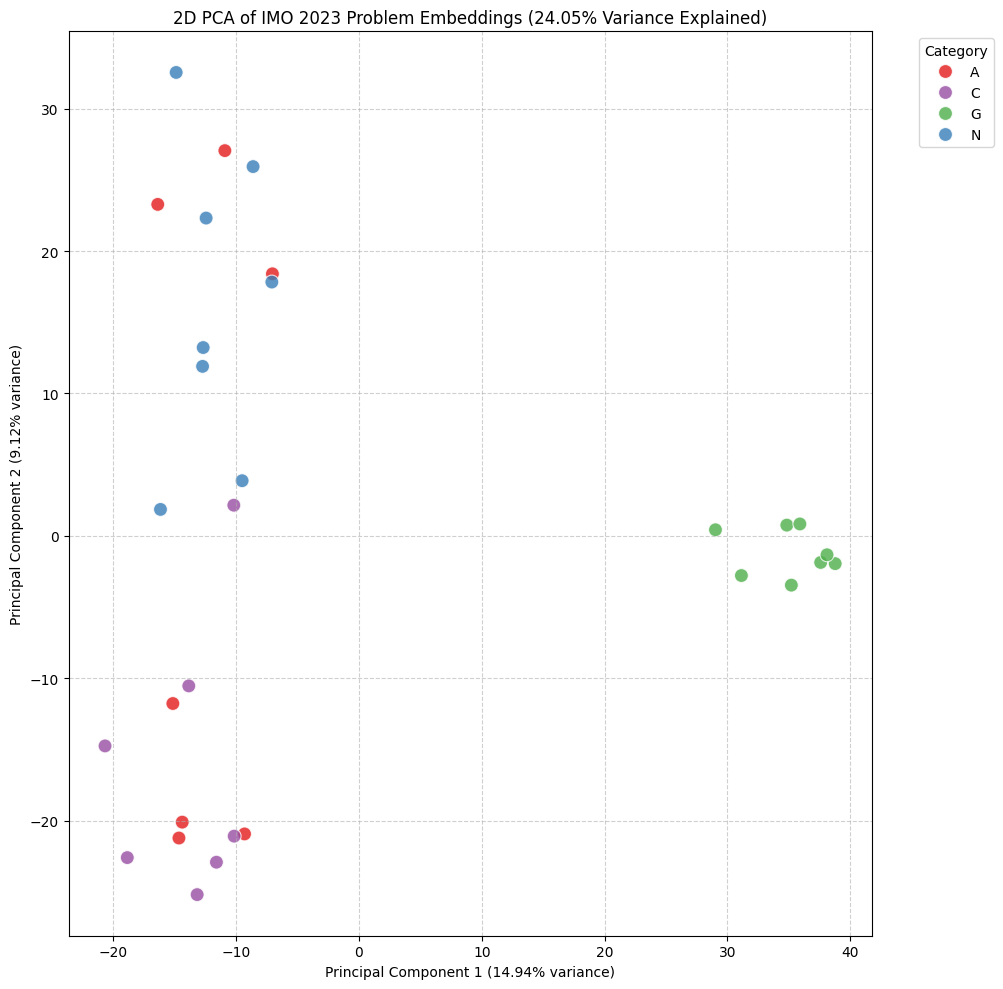

In [18]:
if embeddings is not None:
    print("\n--- Generating 2D Plot ---")
    plt.figure(figsize=FIG_SIZE_2D)
    scatter_2d = sns.scatterplot(
        data=df,
        x='pca1',
        y='pca2',
        hue='category', # Color points by category
        palette=CATEGORY_COLORS, # Use the defined color palette
        s=100, # Adjust marker size
        alpha=0.8 # Adjust marker transparency
    )
    plt.title(f'2D PCA of IMO 2023 Problem Embeddings ({total_variance_2d:.2%} Variance Explained)')
    plt.xlabel(f'Principal Component 1 ({pca_2d.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'Principal Component 2 ({pca_2d.explained_variance_ratio_[1]:.2%} variance)')
    plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left') # Place legend outside plot
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for legend
    # Save the plot
    plot_path_2d = os.path.join(OUTPUT_DIR, 'pca_2d_plot.png')
    plt.savefig(plot_path_2d)
    print(f"Saved 2D plot to: {plot_path_2d}")
    plt.show()

#### 7.2 3D Scatter Plot (Plotly)

In [ ]:
if embeddings is not None:
    print("\n--- Generating 3D Plot ---")
    fig_3d = go.Figure()

    # Add a trace for each category
    for category_name, color in CATEGORY_COLORS.items():
        category_df = df[df['category'] == category_name]
        if not category_df.empty:
            fig_3d.add_trace(go.Scatter3d(
                x=category_df['pca1'],
                y=category_df['pca2'],
                z=category_df['pca3'],
                mode='markers',
                marker=dict(
                    size=6, # Adjust marker size
                    color=color,                # Use the color defined for the category
                    opacity=0.8
                ),
                text=category_df['problem_id'], # Text displayed on hover
                # Custom hover text formatting
                hovertemplate=(
                    f'<b>ID:</b> %{{text}}<br>'
                    f'<b>Category:</b> {category_name}<br>'
                    f'PC1: %{{x:.2f}}<br>'
                    f'PC2: %{{y:.2f}}<br>'
                    f'PC3: %{{z:.2f}}'
                    f'<extra></extra>' # Hide extra hover info
                ),
                name=category_name # Name appearing in the legend
            ))

    # Update layout for titles and axis labels
    fig_3d.update_layout(
        title=f'3D PCA of IMO 2023 Problem Embeddings ({total_variance_3d:.2%} Variance Explained)',
        scene=dict(
            xaxis_title=f'PC 1 ({pca_3d.explained_variance_ratio_[0]:.2f} var)',
            yaxis_title=f'PC 2 ({pca_3d.explained_variance_ratio_[1]:.2f} var)',
            zaxis_title=f'PC 3 ({pca_3d.explained_variance_ratio_[2]:.2f} var)'
        ),
        margin=dict(l=0, r=0, b=0, t=40), # Adjust margins
        legend_title_text='Category',
        # scene_camera = dict( # Optional: set initial camera angle
        #    eye=dict(x=1.8, y=1.8, z=0.6)
        # )
    )

    # Save as interactive HTML (optional)
    plot_path_3d_html = os.path.join(OUTPUT_DIR, 'pca_3d_plot.html')
    fig_3d.write_html(plot_path_3d_html)
    print(f"Saved interactive 3D plot to: {plot_path_3d_html}")

    # Show the plot in the notebook
    fig_3d.show()

### 8. Analysis / Conclusion
Add Markdown cells here to discuss:
- The total variance explained by 2D and 3D PCA. Is it high enough to be representative?
- Observations from the plots: Are the categories visually separated? Is there overlap?
- Any outliers? Any sub-clusters within categories?
- How well do the results support the hypothesis that embeddings capture category-specific semantics?